# Convective Mode Occurences - Deltas - Linear Vs. Cellular Ratios

In [1]:
import pandas as pd
import xarray as xr
import glob
import numpy as np
import xoak
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import colors
import regionmask
import cartopy
import cartopy.crs as ccrs

import scipy as sp
import scipy.ndimage

In [2]:
from matplotlib.colors import ListedColormap, BoundaryNorm


def div_colorbar():
    
    div_colors = ['#053061',
                  '#2166ac',
                  '#4393c3',
                  '#92c5de',
                  '#f7f7f7',
                  '#f4a582',
                  '#d6604d',
                  '#b2182b',
                  '#67001f'
                  ]
    
    cmap = ListedColormap(div_colors)
    
    return cmap

def div_boundarynorm():
    
    
    cmap = div_colorbar()
    classes = np.array(list(np.linspace(-3.5, 3.5, num=9)))
    norm = BoundaryNorm(classes, ncolors=cmap.N) 
    
    return cmap, norm

cmap, norm = div_boundarynorm()

In [3]:
def smooth_it(Patty):
    sigma_y = 1.5
    sigma_x = 1.5
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.gaussian_filter(Patty, sigma, mode='constant')
    return y

## Load the Data

In [4]:
#iterate through the epochs
epochs = ['HIST', 'MID4p5', 'MID8p5', 'END4p5', 'END8p5']

for epoch in epochs:
    
    #load wrf-bcc dataframes
    locals()[f'df_{epoch}'] = pd.concat(map(pd.read_csv, glob.glob(f'/home/scratch/jcorner1/Thesis/future_modes/modes/{epoch}/*')), ignore_index=True)
    locals()[f'df_{epoch}']['Time'] = pd.to_datetime(locals()[f'df_{epoch}']['Time'])
    locals()[f'df_{epoch}']['Month'] = pd.to_datetime( locals()[f'df_{epoch}']['Time']).dt.month

### Mode Information

In [5]:
df_HIST.groupby(['Mode']).count()

Unnamed: 0      x      y  Filename   Time  Month
Mode                                                       
Cellular        81117  81117  81117     81117  81117  81117
Linear          17409  17409  17409     17409  17409  17409
Multicell       46617  46617  46617     46617  46617  46617
Other            6797   6797   6797      6797   6797   6797

In [6]:
df_MID4p5.groupby(['Mode']).count()

Unnamed: 0      x      y  Filename   Time  Month
Mode                                                       
Cellular        97497  97497  97497     97497  97497  97497
Linear          21780  21780  21780     21780  21780  21780
Multicell       62689  62689  62689     62689  62689  62689
Other           11034  11034  11034     11034  11034  11034

In [7]:
df_MID8p5.groupby(['Mode']).count()

Unnamed: 0       x       y  Filename    Time   Month
Mode                                                           
Cellular       106021  106021  106021    106021  106021  106021
Linear          20341   20341   20341     20341   20341   20341
Multicell       67401   67401   67401     67401   67401   67401
Other            8767    8767    8767      8767    8767    8767

In [8]:
df_END4p5.groupby(['Mode']).count()

Unnamed: 0       x       y  Filename    Time   Month
Mode                                                           
Cellular       105158  105158  105158    105158  105158  105158
Linear          24832   24832   24832     24832   24832   24832
Multicell       70396   70396   70396     70396   70396   70396
Other           12724   12724   12724     12724   12724   12724

In [9]:
df_END8p5.groupby(['Mode']).count()

Unnamed: 0       x       y  Filename    Time   Month
Mode                                                           
Cellular       137723  137723  137723    137723  137723  137723
Linear          33510   33510   33510     33510   33510   33510
Multicell       98534   98534   98534     98534   98534   98534
Other           16258   16258   16258     16258   16258   16258

### Convert to Convective Days

In [10]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']
modes = ['Cellular', 'Multicell', 'Linear', 'Other']

#iterate through each epoch
for epoch in epochs:
    for mode in modes:
        geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
        df_wrf = locals()[f'df_{epoch}'][(locals()[f'df_{epoch}']['Mode'] == mode)]

        for season in seasons:
            print(epoch,mode, season)
            if season == 'DJF':
                df_seas = df_wrf[(df_wrf['Month'].isin([12,1,2]))]
            elif season == 'MAM':
                df_seas = df_wrf[(df_wrf['Month'].isin([3,4,5]))]
            elif season == 'JJA':
                df_seas = df_wrf[(df_wrf['Month'].isin([6,7,8]))]
            elif season == 'SON':
                df_seas = df_wrf[(df_wrf['Month'].isin([9,10,11]))]
            uhs = []

            #iterate through the dataframes
            for did, day in df_seas.resample('24h', origin='1990-10-01 12:00:00', on='Time'):

                results = np.zeros(shape=(899, 1399))
                results[day.y.values.astype(int), day.x.values.astype(int)] = 1
                uh_uvv = deepcopy(geog)
                uh_uvv = uh_uvv.assign_coords({'Time': np.array([did])})
                uh_uvv = uh_uvv.assign(UVV_DAYS = (('Time', 'south_north', 'west_east'), np.expand_dims(results, axis=0)))
                uh_uvv = uh_uvv[['CLAT', 'CLONG', 'UVV_DAYS']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
                uh_uvv['UVV_DAYS'] = 1*(uh_uvv['UVV_DAYS'] > 0)

                uhs.append(uh_uvv)

            locals()[f'uhs_{epoch}_{season}_{mode}'] = xr.concat(uhs, dim='Time')

            if epoch != 'HIST': 
                locals()[f'delta_{epoch}_{season}_{mode}'] = (np.sum(locals()[f'uhs_{epoch}_{season}_{mode}'].UVV_DAYS.values, axis=0) - np.sum(locals()[f'uhs_HIST_{season}_{mode}'].UVV_DAYS.values, axis=0)) / 15

HIST Cellular DJF
HIST Cellular MAM
HIST Cellular JJA
HIST Cellular SON
HIST Multicell DJF
HIST Multicell MAM
HIST Multicell JJA
HIST Multicell SON
HIST Linear DJF
HIST Linear MAM
HIST Linear JJA
HIST Linear SON
HIST Other DJF
HIST Other MAM
HIST Other JJA
HIST Other SON
MID4p5 Cellular DJF
MID4p5 Cellular MAM
MID4p5 Cellular JJA
MID4p5 Cellular SON
MID4p5 Multicell DJF
MID4p5 Multicell MAM
MID4p5 Multicell JJA
MID4p5 Multicell SON
MID4p5 Linear DJF
MID4p5 Linear MAM
MID4p5 Linear JJA
MID4p5 Linear SON
MID4p5 Other DJF
MID4p5 Other MAM
MID4p5 Other JJA
MID4p5 Other SON
MID8p5 Cellular DJF
MID8p5 Cellular MAM
MID8p5 Cellular JJA
MID8p5 Cellular SON
MID8p5 Multicell DJF
MID8p5 Multicell MAM
MID8p5 Multicell JJA
MID8p5 Multicell SON
MID8p5 Linear DJF
MID8p5 Linear MAM
MID8p5 Linear JJA
MID8p5 Linear SON
MID8p5 Other DJF
MID8p5 Other MAM
MID8p5 Other JJA
MID8p5 Other SON
END4p5 Cellular DJF
END4p5 Cellular MAM
END4p5 Cellular JJA
END4p5 Cellular SON
END4p5 Multicell DJF
END4p5 Multicell MA

## Convective Mode Occurences

/tmp/ipykernel_7749/1126501260.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


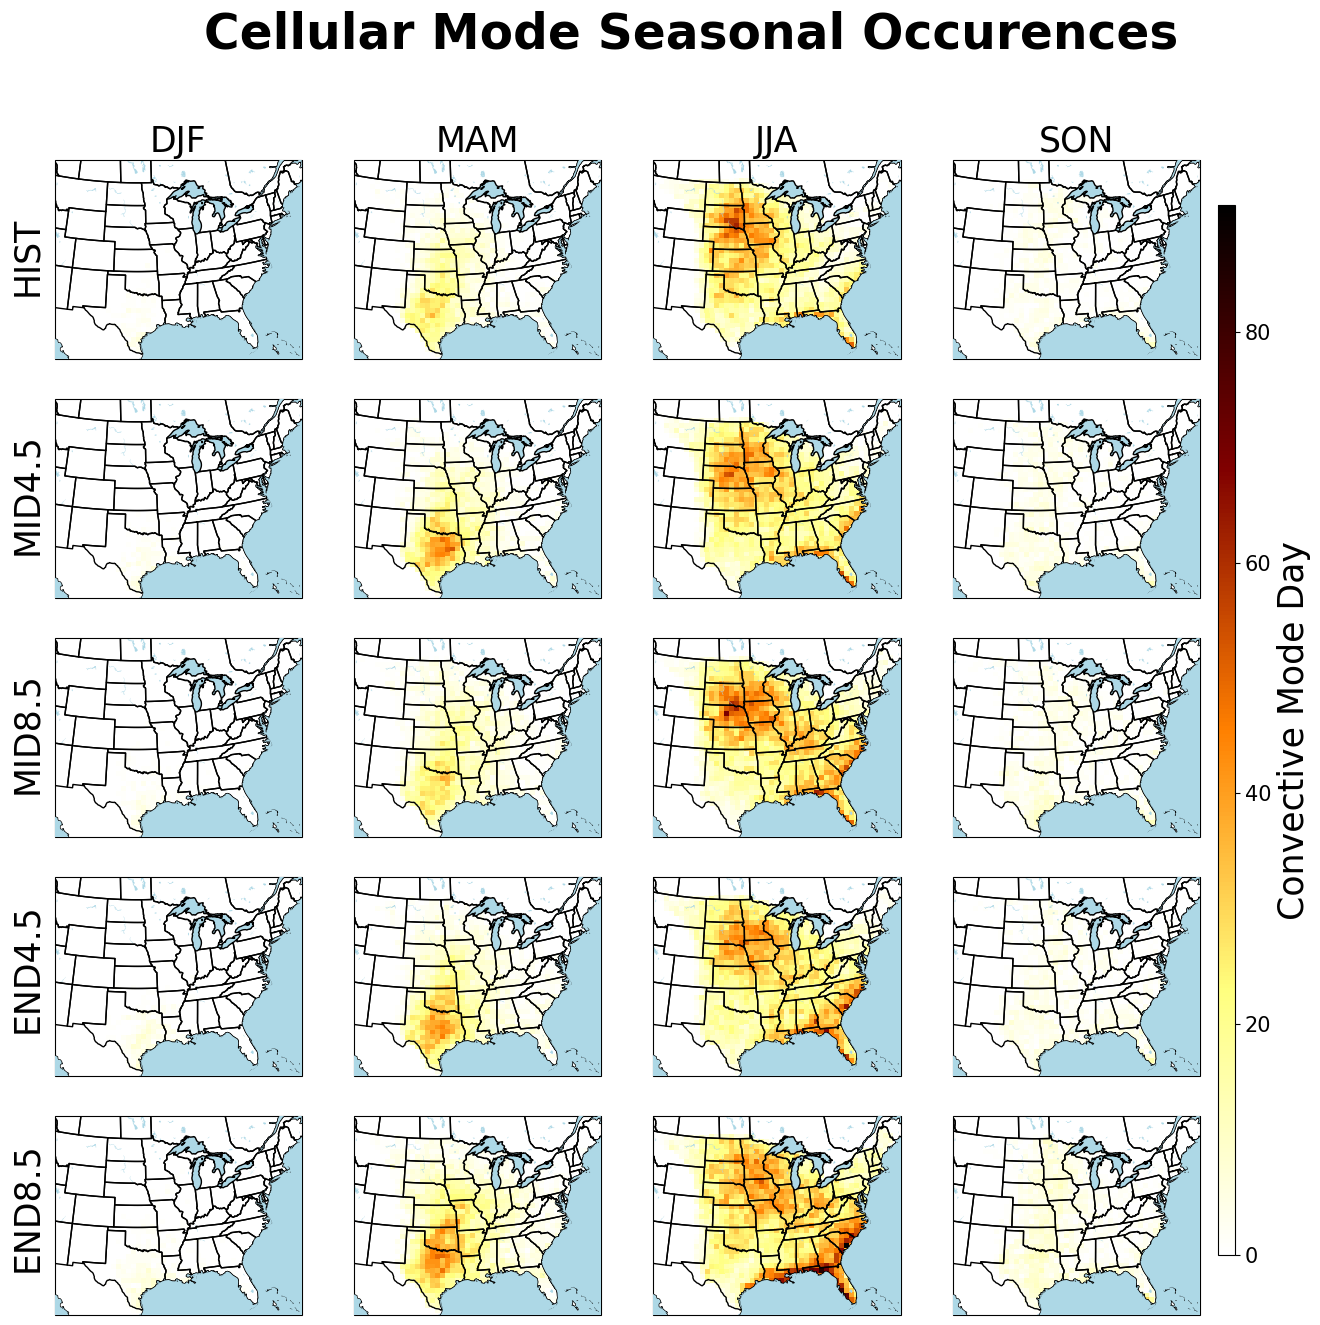

In [11]:
fig = plt.figure(figsize=(17,15))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
epoch_labels = ['HIST', 'MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Cellular Mode Seasonal Occurences', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x=1

for epoch in range(len(epochs)):
    for season in seasons:
        ax = plt.subplot(5, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(locals()[f'uhs_{epochs[epoch]}_{season}_Cellular'].CLONG.values[0,:,:], locals()[f'uhs_{epochs[epoch]}_{season}_Cellular'].CLAT.values[0,:,:],
                          np.sum(locals()[f'uhs_{epochs[epoch]}_{season}_Cellular'].UVV_DAYS.values, axis=0),
                          transform=cartopy.crs.PlateCarree(), cmap='afmhot_r', vmax=91)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='gray')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{season}',fontsize=25)
            
        if x in [5, 9, 13, 17]:
            #ax.set_ylabel(f'{epoch_labels[epoch]}',fontsize=25)
            ax.annotate(f'{epoch_labels[epoch]}', xy=(-0.18,0.25), xycoords='axes fraction', fontsize=25, rotation='vertical')
            
        if x == 1:
            ax.annotate(f'{epoch_labels[epoch]}', xy=(-0.18,0.35), xycoords='axes fraction', fontsize=25, rotation='vertical')
            
        x=x+1
        
    
cbar = plt.colorbar(c, pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='Convective Mode Day', size=25)

/tmp/ipykernel_7749/2413777991.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


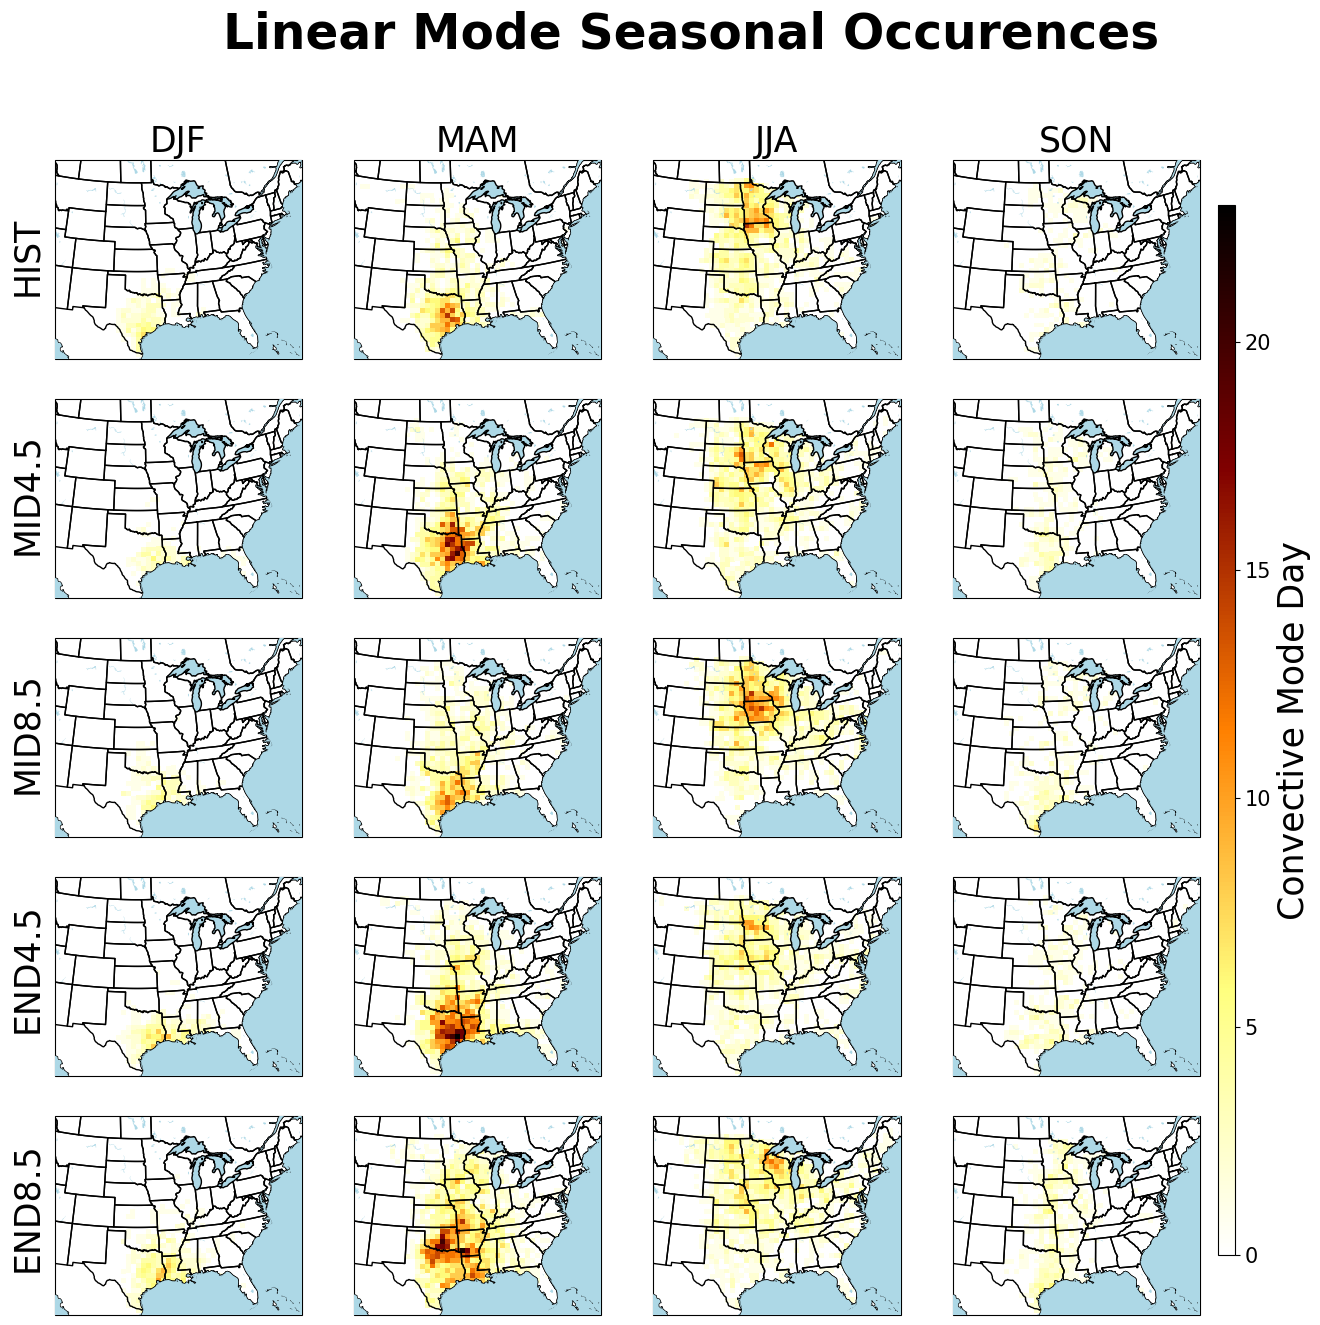

In [12]:
fig = plt.figure(figsize=(17,15))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
epoch_labels = ['HIST', 'MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Linear Mode Seasonal Occurences', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x=1

for epoch in range(len(epochs)):
    for season in seasons:
        ax = plt.subplot(5, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(locals()[f'uhs_{epochs[epoch]}_{season}_Linear'].CLONG.values[0,:,:], locals()[f'uhs_{epochs[epoch]}_{season}_Linear'].CLAT.values[0,:,:],
                          np.sum(locals()[f'uhs_{epochs[epoch]}_{season}_Linear'].UVV_DAYS.values, axis=0),
                          transform=cartopy.crs.PlateCarree(), cmap='afmhot_r', vmax=23)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='gray')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{season}',fontsize=25)
            
        if x in [5, 9, 13, 17]:
            #ax.set_ylabel(f'{epoch_labels[epoch]}',fontsize=25)
            ax.annotate(f'{epoch_labels[epoch]}', xy=(-0.18,0.25), xycoords='axes fraction', fontsize=25, rotation='vertical')
            
        if x == 1:
            ax.annotate(f'{epoch_labels[epoch]}', xy=(-0.18,0.35), xycoords='axes fraction', fontsize=25, rotation='vertical')
            
        x=x+1
    
cbar = plt.colorbar(c, pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='Convective Mode Day', size=25)

## Convective Mode Deltas

/tmp/ipykernel_7749/2437841471.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


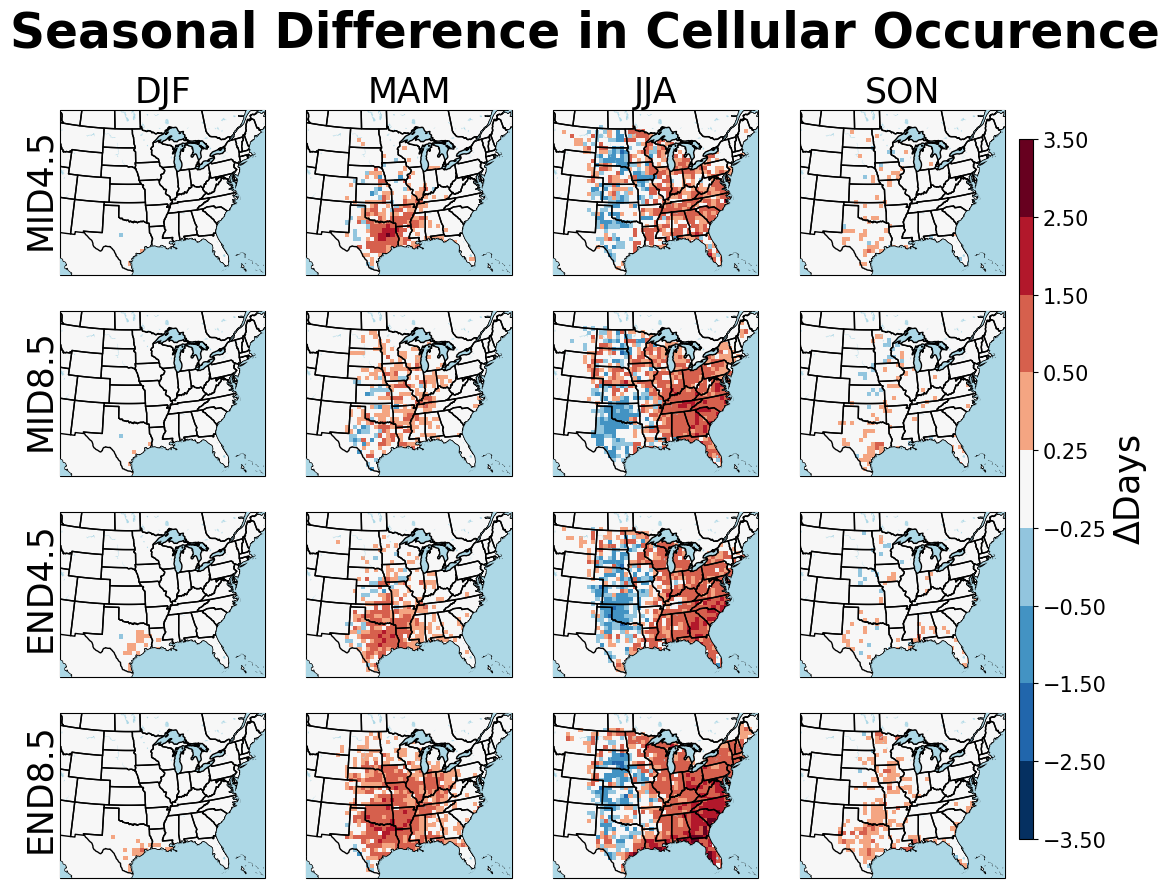

In [13]:
#Plot the data
fig = plt.figure(figsize=(14,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

divnorm = colors.BoundaryNorm([-3.5,-2.5,-1.5,-0.5, -0.25, 0.25, 0.5, 1.5, 2.5, 3.5], 9)
epoch_labels = ['MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Seasonal Difference in Cellular Occurence', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x = 1

for i in range(len(epochs[1:])):
    for j in range(len(seasons)):

        ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(uhs_MID4p5_DJF_Cellular.CLONG.values[0,:,:], 
                          uhs_MID4p5_DJF_Cellular.CLAT.values[0,:,:],
                          locals()[f'delta_{epochs[1:][i]}_{seasons[j]}_Cellular'],
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='gray')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{seasons[j]}',fontsize=25)
            
        if x in [1, 5, 9, 13]:
            #plt.ylabel(,fontsize=25)
            ax.annotate(f'{epoch_labels[i]}', xy=(-0.18,0.2), xycoords='axes fraction', fontsize=25, rotation='vertical')
        
        x=x+1
        
        
cbar = plt.colorbar(c,ticks=[-3.5,-2.5,-1.5,-0.5, -0.25, 0.25, 0.5, 1.5, 2.5, 3.5], pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='$\Delta$Days', size=25)
plt.savefig('/home/jcorner1/Future_Modes/Plots/cellular_Seasonal_deltas.png', format='png', dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_7749/2993782693.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


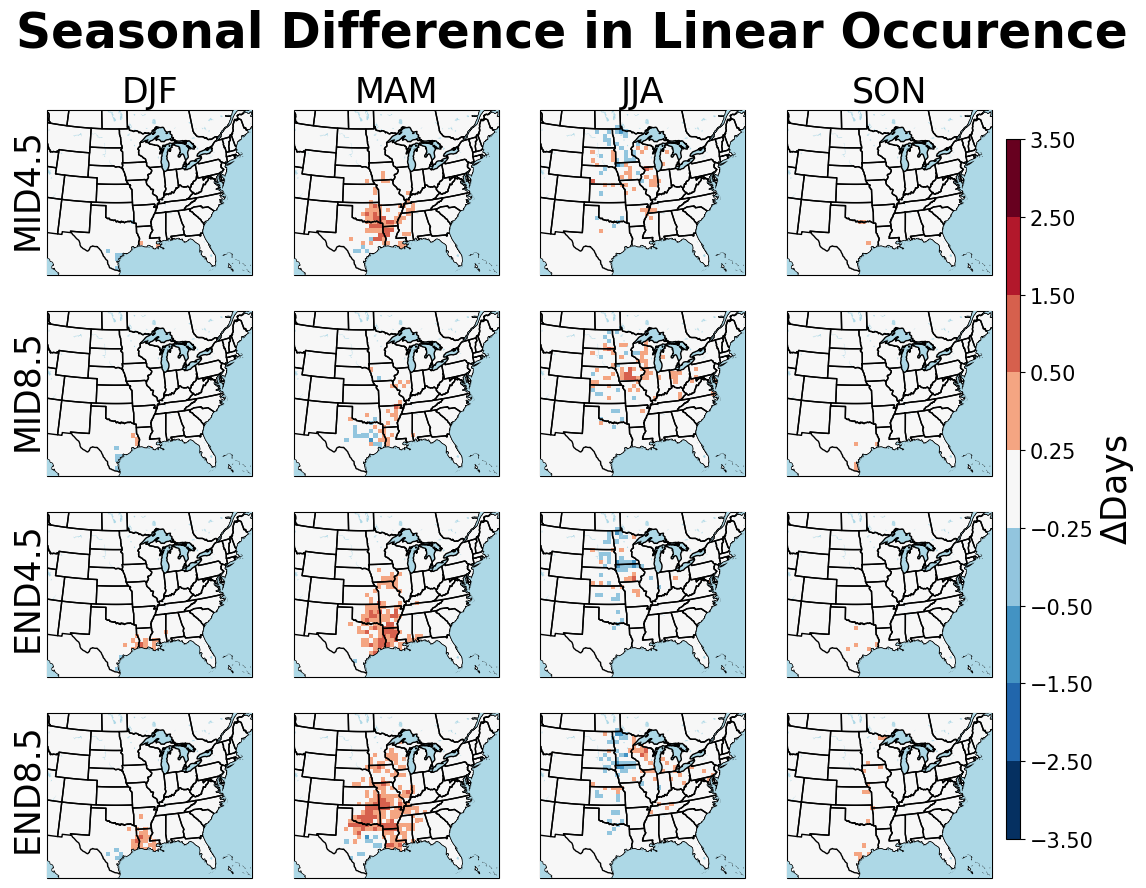

In [14]:
#Plot the data
fig = plt.figure(figsize=(14,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

#divnorm=colors.TwoSlopeNorm(vmin=-4.5, vcenter=0., vmax=4.5)
divnorm = colors.BoundaryNorm([-3.5,-2.5,-1.5,-0.5, -0.25, 0.25, 0.5, 1.5, 2.5, 3.5], 9)
epoch_labels = ['MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Seasonal Difference in Linear Occurence', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x = 1

for i in range(len(epochs[1:])):
    for j in range(len(seasons)):

        ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(uhs_MID4p5_DJF_Cellular.CLONG.values[0,:,:], 
                          uhs_MID4p5_DJF_Cellular.CLAT.values[0,:,:],
                          locals()[f'delta_{epochs[1:][i]}_{seasons[j]}_Linear'],
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='gray')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{seasons[j]}',fontsize=25)
            
        if x in [1, 5, 9, 13]:
            #plt.ylabel(,fontsize=25)
            ax.annotate(f'{epoch_labels[i]}', xy=(-0.18,0.2), xycoords='axes fraction', fontsize=25, rotation='vertical')
        
        x=x+1
        
        
    
cbar = plt.colorbar(c,ticks=[-3.5,-2.5,-1.5,-0.5, -0.25, 0.25, 0.5, 1.5, 2.5, 3.5], pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='$\Delta$Days', size=25)
plt.savefig('/home/jcorner1/Future_Modes/Plots/linear_Seasonal_deltas.png', format='png', dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_7749/2164632820.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


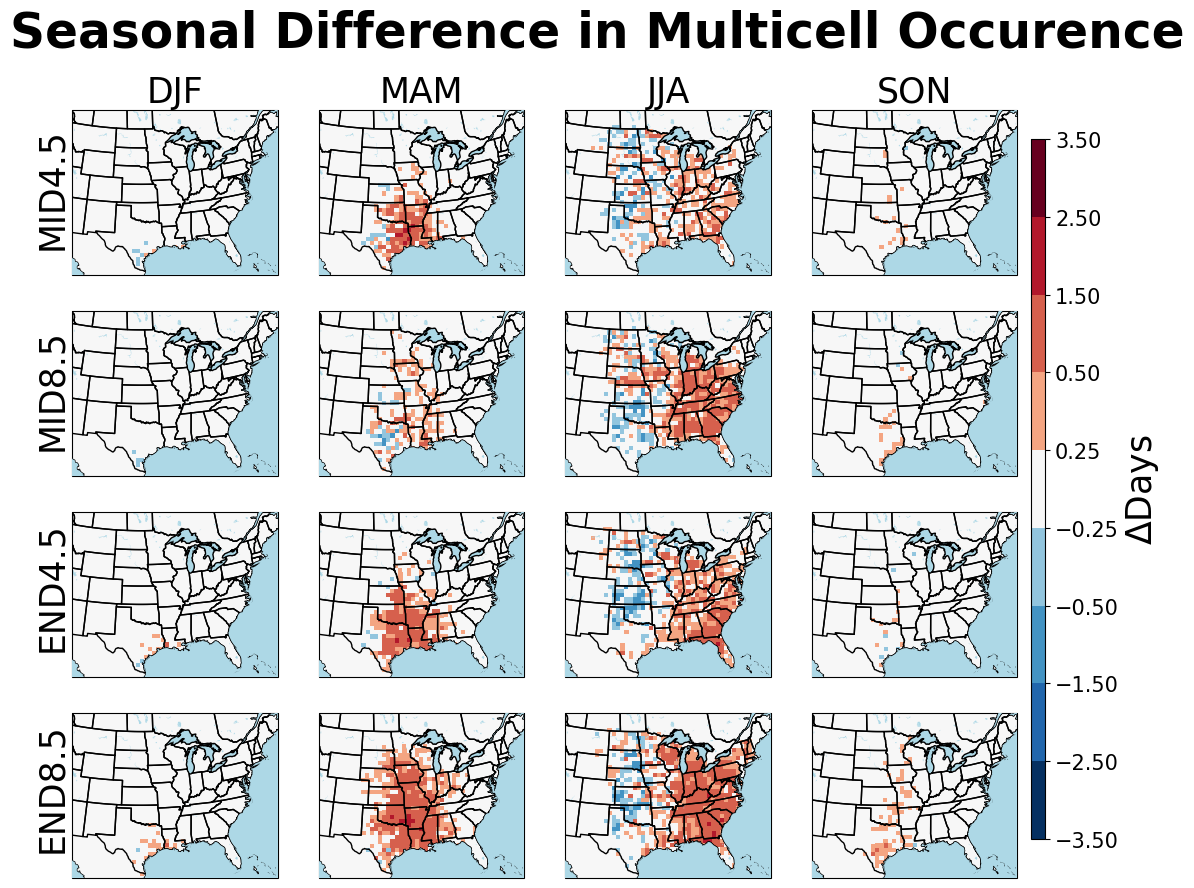

In [15]:
#Plot the data
fig = plt.figure(figsize=(14,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

divnorm = colors.BoundaryNorm([-3.5,-2.5,-1.5,-0.5, -0.25, 0.25, 0.5, 1.5, 2.5, 3.5], 9)
epoch_labels = ['MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Seasonal Difference in Multicell Occurence', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x = 1

for i in range(len(epochs[1:])):
    for j in range(len(seasons)):

        ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(uhs_MID4p5_DJF_Cellular.CLONG.values[0,:,:], 
                          uhs_MID4p5_DJF_Cellular.CLAT.values[0,:,:],
                          locals()[f'delta_{epochs[1:][i]}_{seasons[j]}_Multicell'],
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='gray')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{seasons[j]}',fontsize=25)
            
        if x in [1, 5, 9, 13]:
            #plt.ylabel(,fontsize=25)
            ax.annotate(f'{epoch_labels[i]}', xy=(-0.18,0.2), xycoords='axes fraction', fontsize=25, rotation='vertical')
        
        x=x+1
        
        
    
cbar = plt.colorbar(c,ticks=[-3.5,-2.5,-1.5,-0.5, -0.25, 0.25, 0.5, 1.5, 2.5, 3.5], pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='$\Delta$Days', size=25)
plt.savefig('/home/jcorner1/Future_Modes/Plots/mixedmode_Seasonal_deltas.png', format='png', dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_7749/1681017000.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


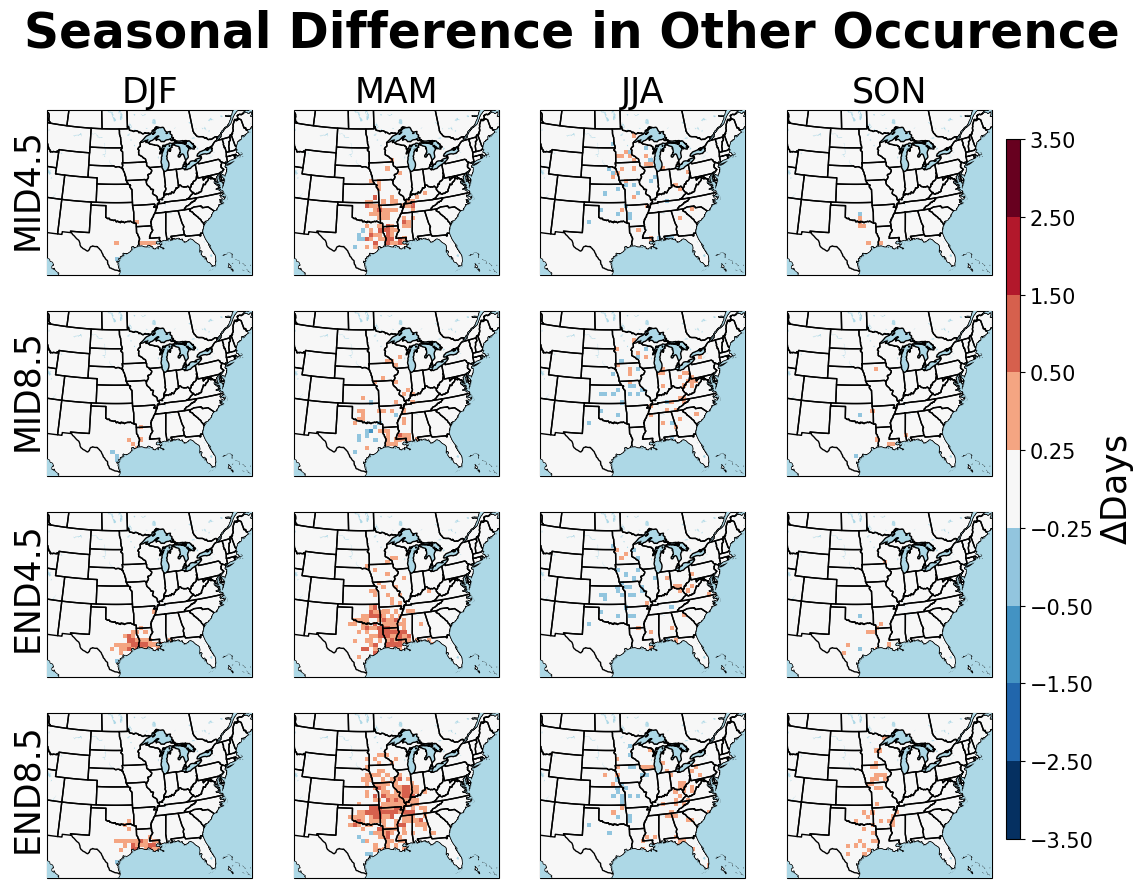

In [16]:
#Plot the data
fig = plt.figure(figsize=(14,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

#divnorm=colors.TwoSlopeNorm(vmin=-4.5, vcenter=0., vmax=4.5)
divnorm = colors.BoundaryNorm([-3.5,-2.5,-1.5,-0.5, -0.25, 0.25, 0.5, 1.5, 2.5, 3.5], 9)
epoch_labels = ['MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Seasonal Difference in Other Occurence', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x = 1

for i in range(len(epochs[1:])):
    for j in range(len(seasons)):

        ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(uhs_MID4p5_DJF_Cellular.CLONG.values[0,:,:], 
                          uhs_MID4p5_DJF_Cellular.CLAT.values[0,:,:],
                          locals()[f'delta_{epochs[1:][i]}_{seasons[j]}_Other'],
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='gray')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{seasons[j]}',fontsize=25)
            
        if x in [1, 5, 9, 13]:
            #plt.ylabel(,fontsize=25)
            ax.annotate(f'{epoch_labels[i]}', xy=(-0.18,0.2), xycoords='axes fraction', fontsize=25, rotation='vertical')
        
        x=x+1
        
        
    
cbar = plt.colorbar(c,ticks=[-3.5,-2.5,-1.5,-0.5, -0.25, 0.25, 0.5, 1.5, 2.5, 3.5], pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='$\Delta$Days', size=25)
plt.savefig('/home/jcorner1/Future_Modes/Plots/other_Seasonal_deltas.png', format='png', dpi=500, bbox_inches='tight')
plt.show()

## Cellular Vs. Linear Ratios

In [17]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds_mask: a masked xarray dataset
    
    '''
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds_coar = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds_coar.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    
    return ds_coar

#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc').sel(Time='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()
ds_copy_cor = Data_Conv(ds_copy)

In [21]:
for epoch in epochs:
    for mode in ['Cellular', 'Multicell']:
        geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
        df_wrf = locals()[f'df_{epoch}'][(locals()[f'df_{epoch}']['Mode'] == mode)]

        for season in seasons:
            print(epoch, mode, season)
            if season == 'DJF':
                df_seas = df_wrf[(df_wrf['Month'].isin([12,1,2]))]
            elif season == 'MAM':
                df_seas = df_wrf[(df_wrf['Month'].isin([3,4,5]))]
            elif season == 'JJA':
                df_seas = df_wrf[(df_wrf['Month'].isin([6,7,8]))]
            elif season == 'SON':
                df_seas = df_wrf[(df_wrf['Month'].isin([9,10,11]))]
            
            results = np.zeros(shape=(899, 1399))
            
            #iterate through the dataframes
            for did, day in df_seas.iterrows():
            
                results[day.y, day.x] = results[day.y, day.x] + 1
                
            uh_uvv = ds_copy.assign(UVV_DAYS = (('south_north', 'west_east'), results))
            locals()[f'{epoch}_{season}_{mode}_counts'] = Data_Conv(uh_uvv)
                
                
            if mode == 'Multicell':
                locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values

HIST Cellular DJF
HIST Cellular MAM
HIST Cellular JJA
HIST Cellular SON
HIST Multicell DJF


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


HIST Multicell MAM


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


HIST Multicell JJA


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


HIST Multicell SON


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


MID4p5 Cellular DJF
MID4p5 Cellular MAM
MID4p5 Cellular JJA
MID4p5 Cellular SON
MID4p5 Multicell DJF


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


MID4p5 Multicell MAM


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


MID4p5 Multicell JJA


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


MID4p5 Multicell SON


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


MID8p5 Cellular DJF
MID8p5 Cellular MAM
MID8p5 Cellular JJA
MID8p5 Cellular SON
MID8p5 Multicell DJF


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


MID8p5 Multicell MAM


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


MID8p5 Multicell JJA


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


MID8p5 Multicell SON


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


END4p5 Cellular DJF
END4p5 Cellular MAM
END4p5 Cellular JJA
END4p5 Cellular SON
END4p5 Multicell DJF


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


END4p5 Multicell MAM


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


END4p5 Multicell JJA


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


END4p5 Multicell SON


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


END8p5 Cellular DJF
END8p5 Cellular MAM
END8p5 Cellular JJA
END8p5 Cellular SON
END8p5 Multicell DJF


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


END8p5 Multicell MAM


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


END8p5 Multicell JJA


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


END8p5 Multicell SON


/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: divide by zero encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values
/tmp/ipykernel_7749/2993674610.py:29: RuntimeWarning: invalid value encountered in divide
  locals()[f'{epoch}_{season}_ratio'] = locals()[f'{epoch}_{season}_Cellular_counts'].UVV_DAYS.values / locals()[f'{epoch}_{season}_Multicell_counts'].UVV_DAYS.values


/tmp/ipykernel_7749/4235760122.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))


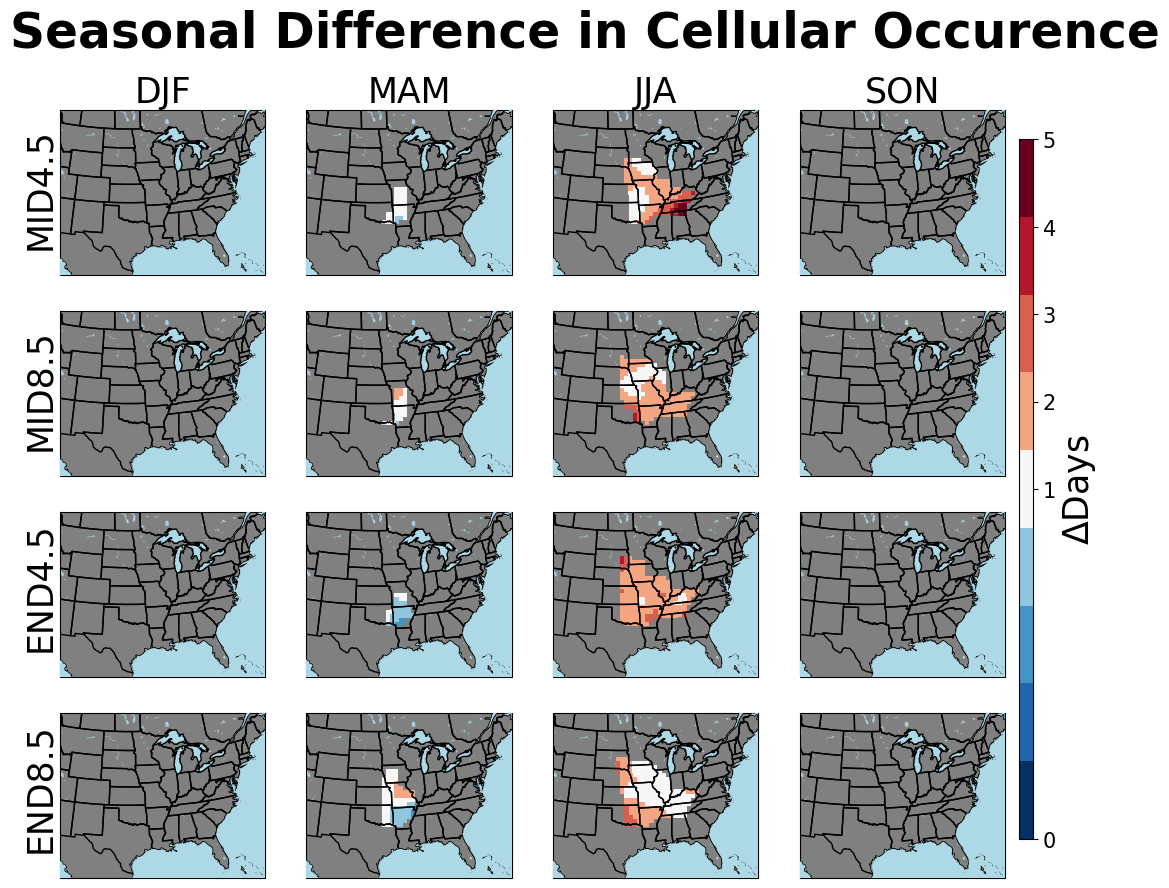

In [23]:
#Plot the data
fig = plt.figure(figsize=(14,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

divnorm=colors.TwoSlopeNorm(vmin=0, vcenter=1., vmax=5)
epoch_labels = ['MID4.5', 'MID8.5', 'END4.5', 'END8.5']

plt.subplots_adjust(right=0.8)
title = plt.suptitle('Seasonal Difference in Cellular Occurence', size=35).set_weight('bold')
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])

x = 1

for i in range(len(epochs[1:])):
    for j in range(len(seasons)):

        ax = plt.subplot(4, 4, x, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
        c = ax.pcolormesh(uhs_MID4p5_DJF_Cellular.CLONG.values[0,:,:], 
                          uhs_MID4p5_DJF_Cellular.CLAT.values[0,:,:],
                          smooth_it(locals()[f'{epochs[1:][i]}_{seasons[j]}_ratio']),
                          transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=divnorm)

        ax.add_feature(cartopy.feature.STATES, zorder=2)
        ax.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax.add_feature(cartopy.feature.LAND, facecolor='gray')
        ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=3)
        ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

        ax.set_extent([-110, -74, 24.5, 50])

        #ax.annotate(f'{epochs[1:][i]} - ', (0.05,0.05),fontsize=16, xycoords='axes fraction')
        
        if x <= 4:
            plt.title(f'{seasons[j]}',fontsize=25)
            
        if x in [1, 5, 9, 13]:
            #plt.ylabel(,fontsize=25)
            ax.annotate(f'{epoch_labels[i]}', xy=(-0.18,0.2), xycoords='axes fraction', fontsize=25, rotation='vertical')
        
        x=x+1
        
        
    
cbar = plt.colorbar(c, pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='$\Delta$Days', size=25)
#plt.savefig('../Plots/Seasonal_deltas.png', format='png', dpi=500, bbox_inches='tight')
plt.show()